# Проект Выбор локации для скважины

Заказчик исследования - добывающая компания «ГлавРосГосНефть».

**Цель проекта** - выбрать регион, в котором следует бурить новую скважину для добычи нефти.

Заказчик предоставил пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерено качество нефти и объём её запасов. Необходимо определить регион, где добыча принесёт наибольшую прибыль. Возможную прибыль и риски следует проанализировать техникой *Bootstrap.*

Для достижения указанной цели необходимо осуществить следующие шаги:     
1. Изучить предоставленные данные о пробах нефти. Обнаружить и устранить возможные проблемы в данных (дубли, пропуски, аномалии);    
2. Определить целевые и входные признаки для разработки модели машинного обучения. Проанализировать характер взаимосвязей между целевыми и входными признаками;     
3. Обучить модель и сделать предсказание запасов нефти на валидационной выборке для каждого региона. Размер валидационной выборки - 25% от предоставленного датасета;     
4. Выбрать скважины с максимальным значением предсказания, рассчитать для них прибыль на основании предсказанных объемов сырья;     
5. Для каждого региона определить среднюю прибыль, 95% доверительный интервал и риск убытков. Убытком считается отрицательное значение прибыли;     
6. Определить регион, добыча нефти в котором принесет максимальную прибыль при минимальных рисках.    

Также есть ряд условий заказчика, которые необходимо учесть при работе над проектом:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые);     
- Качество модели оценивается метрикой RMSE;     
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки;     
- Бюджет на разработку скважин в регионе — 10 млрд рублей;     
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей;      
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.     


**Описание данных**     

***Данные геологоразведки для трех регионов*** - файлы geo_data_0.csv, geo_data_1.csv и geo_data_2.csv     
*id* — уникальный идентификатор скважины      
*f0, f1, f2* — признаки точек (подробное описание отсутствует, но, по информации от заказчика, признаки значимы)     
*product* — объём запасов в скважине (тыс. баррелей).


## 1. Загрузка и подготовка данных

### 1.1. Загрузка данных

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats as st

In [ ]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

Изучим каждую таблицу данных.

In [ ]:
tables = [geo_data_0, geo_data_1, geo_data_2]
i=0
for table in tables:
    print(f'Таблица geo_data_{i}')
    display(table.head())
    table.info()
    i+=1
    print()

Таблица geo_data_0


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Таблица geo_data_1


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Таблица geo_data_2


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB



Для каждого региона предоставлены данные о 100000 скважин. Содержание и тип данных соответствуют описанию. На первый взгляд, пропуски отсутствуют.    

Проведем предобработку данных.

### 1.2. Предобработка данных

На этапе чтения файлов с данными пропуски не обнаружены.    

Проверим таблицы на предмет наличия полных дублей.

In [ ]:
print(f'Количество полных дублей в таблице geo_data_0:', geo_data_0.duplicated().sum())
print(f'Количество полных дублей в таблице geo_data_1:', geo_data_1.duplicated().sum())
print(f'Количество полных дублей в таблице geo_data_2:', geo_data_2.duplicated().sum())

Количество полных дублей в таблице geo_data_0: 0
Количество полных дублей в таблице geo_data_1: 0
Количество полных дублей в таблице geo_data_2: 0


Полных дублей строк в таблицах нет. Проверим, нет ли дублей скважин по id.

In [ ]:
print('Количество дублей по id в таблице geo_data_0:', geo_data_0['id'].duplicated().sum())
print('Количество дублей по id в таблице geo_data_1:', geo_data_1['id'].duplicated().sum())
print('Количество дублей по id в таблице geo_data_2:', geo_data_2['id'].duplicated().sum())

Количество дублей по id в таблице geo_data_0: 10
Количество дублей по id в таблице geo_data_1: 4
Количество дублей по id в таблице geo_data_2: 4


В каждой из таблиц есть скважины с одинаковым id, но c разными характеристиками. Посмотрим на эти скважины на примере таблицы geo_data_0

In [ ]:
dup_id0 = geo_data_0[geo_data_0['id'].duplicated()]['id']
display(geo_data_0.query('id in @dup_id0').sort_values(by='id'))

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


У скважин одинаковые идентификаторы, но абсолютно разные характеристики, включая значение целевого признака - объем запасов нефти. Полагаю, что здесь имеет место человеческий фактор - разные скважины по ошибке названы одинаково. Учитывая общее количество скважин в каждом из датасетов (100000), наличие данной ошибки неудивительно. У нас нет оснований сомневаться в достоверности данных по дублирующим скважинам, а значит удалять их из датасета нецелесообразно.

Поэтому на текущем этапе сохраним id всех дублей в отдельные списки для предоставления заказчику. id для файла geo_data_0 уже сохранены в переменной dup_id0. Создадим аналогичные переменные для других таблиц.

In [ ]:
dup_id1 = geo_data_1[geo_data_1['id'].duplicated()]['id']
dup_id2 = geo_data_2[geo_data_2['id'].duplicated()]['id']
display(dup_id1.head())
display(dup_id2.head())

41906    LHZR0
82178    bfPNe
82873    wt4Uk
84461    5ltQ6
Name: id, dtype: object

43233    xCHr8
49564    VF7Jo
55967    KUPhW
95090    Vcm5J
Name: id, dtype: object

Исключая id, все признаки в датасетах количественные, а поэтому на неявные дубликаты проверять датасеты не будем.    
Для удобства дальнейшего анализа исключим из датасетов id. Для достижения цели исследования нам не потребуются эти данные.

In [ ]:
geo_data_0 = geo_data_0.drop('id', axis=1)
geo_data_1 = geo_data_1.drop('id', axis=1)
geo_data_2 = geo_data_2.drop('id', axis=1)

Проведем исследовательский анализ данных.

### 1.3. Исследовательский анализ данных

Проанализируем распределения значений признаков в датасетов.

Характеристики распределений признаков в geo_data_0


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Характеристики распределений признаков в geo_data_1


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


Характеристики распределений признаков в geo_data_2


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


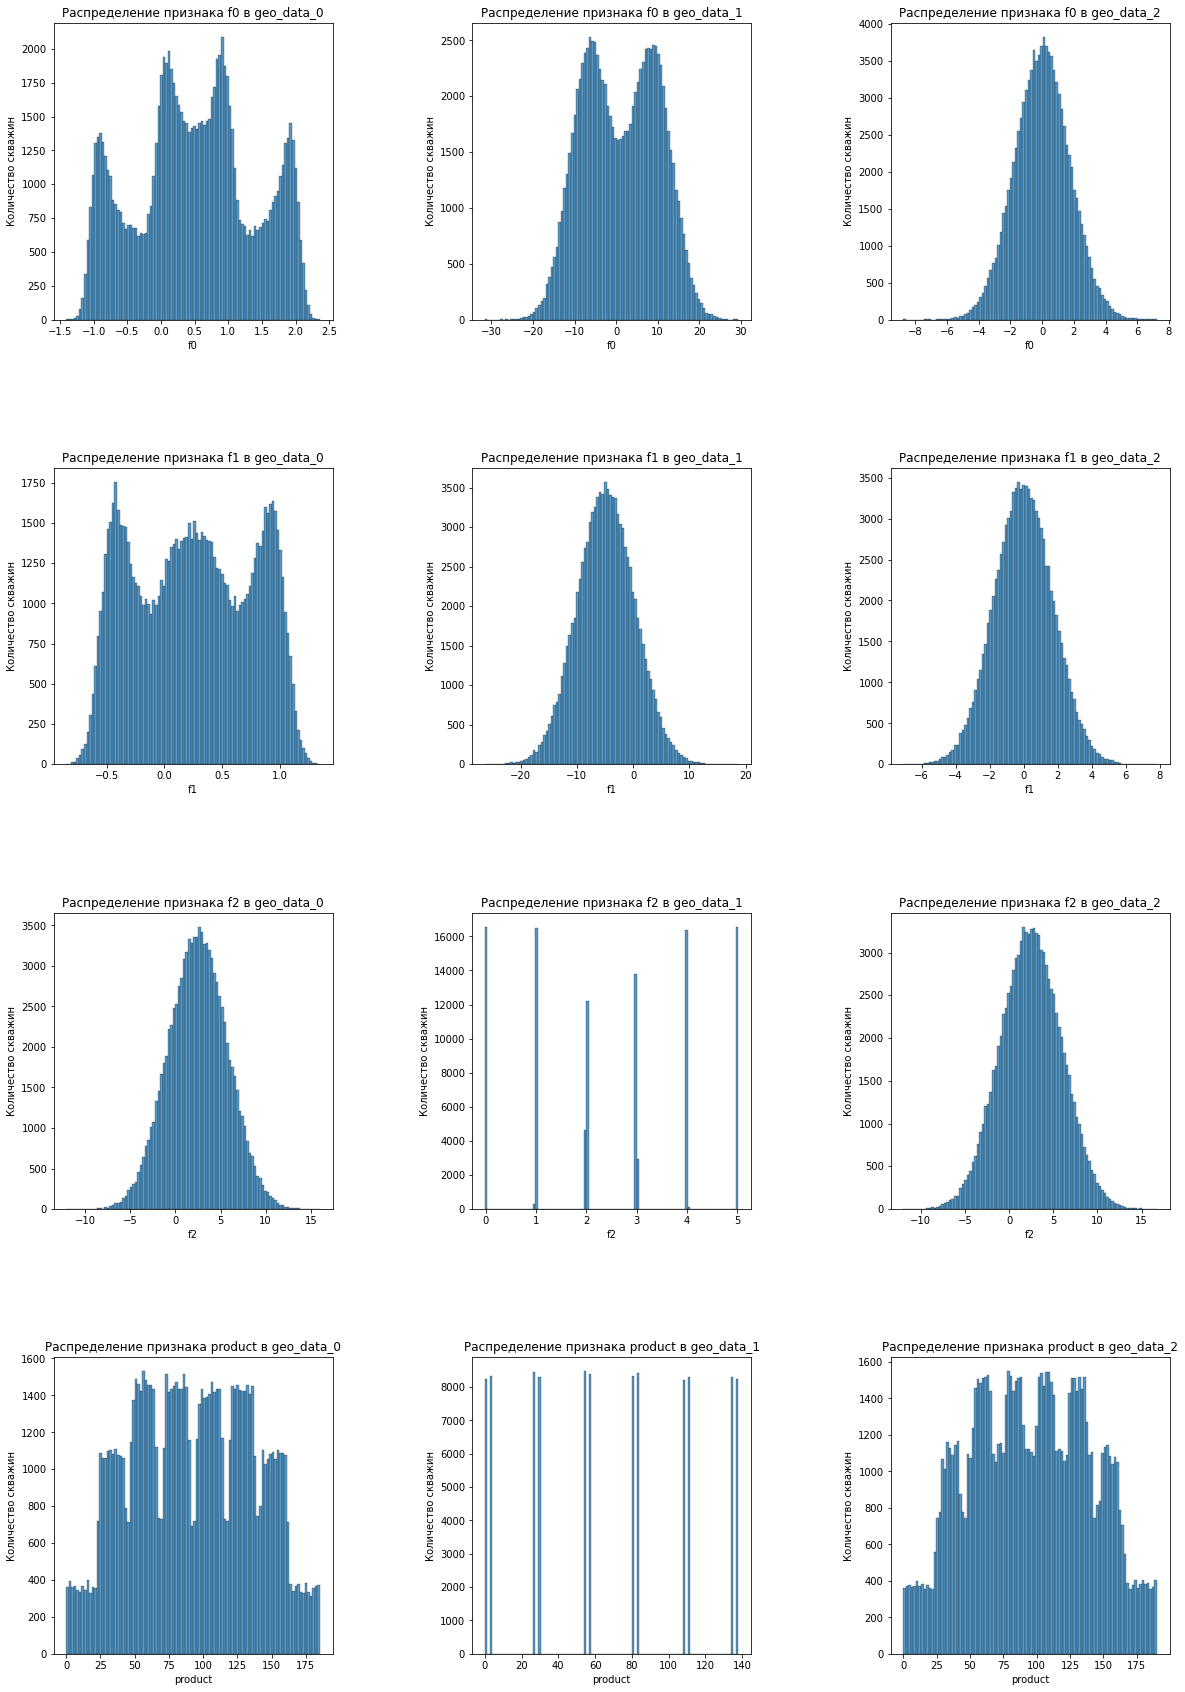

In [ ]:
cols = ['f0', 'f1', 'f2', 'product']
print('Характеристики распределений признаков в geo_data_0')
display(geo_data_0.describe())
print('Характеристики распределений признаков в geo_data_1')
display(geo_data_1.describe())
print('Характеристики распределений признаков в geo_data_2')
display(geo_data_2.describe())
i=0
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20,30))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
axe = axes.ravel()
for col in cols:
        sns.histplot(geo_data_0[col], kde=False, bins=100, ax=axe[i])
        axe[i].set_title(f'Распределение признака {col} в geo_data_0')
        axe[i].set_xlabel(col)
        axe[i].set_ylabel('Количество скважин')
        sns.histplot(geo_data_1[col], kde=False, bins=100, ax=axe[i+1])
        axe[i+1].set_title(f'Распределение признака {col} в geo_data_1')
        axe[i+1].set_xlabel(col)
        axe[i+1].set_ylabel('Количество скважин')
        sns.histplot(geo_data_2[col], kde=False, bins=100, ax=axe[i+2])
        axe[i+2].set_title(f'Распределение признака {col} в geo_data_2')
        axe[i+2].set_xlabel(col)
        axe[i+2].set_ylabel('Количество скважин')
        i+=3

Распределение значений признаков скважин различается во всех трех датасетах. Причем, это касается как характера распределений, так и диапазона значений. Например, если мы возьмем признак f0, в первой таблице его значения находятся в диапазоне от -1.40 до 2.36, во второй - в диапазоне от примерно -32 до 30 . а в третьей - от -9 до 7. Признак f2 в geo_data_0 и geo_data_2 имеет почти идеально нормальное распределение, в то время как в geo_data_1 его значения сгруппировались вокруг конкретных цифр.

Мы не знаем, какие именно характеристики скрываются за признаками f0, f1 и f2, а поэтому сложно сделать вывод о реалистичности либо нереалистичности их значений в таблицах. Однако, учитывая графики распределений и разброс значений признаков в датасетах, могу сделать вывод:
- регионы, в которых находятся скважины для каждого из датасетов, значительно различаются по своим характеристикам;     

либо    

- за признаками f0, f1 и f2 в каждом из датасетов скрываются разные характеристики точек;   

либо   

- f0, f1 и f2 это географические координаты скважин, и за нулевой километр, относительно которого произведен расчет координат, взята некая точка из региона geo_data_0, а регионы geo_data_1 и geo_data_2 находятся на разном удалении от этой точки.

В любом случае, наблюдаемая разница не помешает нам построить модели и сделать предсказания, так как данные из таблиц не будут пересекаться между собой.

Отдельно стоит рассмотреть распределение объемов запасов нефти (product). В каждом из датасетов есть скважины с нулевыми значениями данного признака. Посмотрим, сколько их.

In [ ]:
print('Количество пустых скважин в geo_data_0:', geo_data_0.query('product==0').shape[0])
print('Количество пустых скважин в geo_data_1:', geo_data_1.query('product==0').shape[0])
print('Количество пустых скважин в geo_data_2:', geo_data_2.query('product==0').shape[0])

Количество пустых скважин в geo_data_0: 1
Количество пустых скважин в geo_data_1: 8235
Количество пустых скважин в geo_data_2: 1


В первом и третьем регионах по 1 пустой скважине, а вот во 2-м 8235 - это 8% от всего региона.    

Вряд ли заказчик планирует разработку пустых скважин, однако удалять из датасета их не будем. Во-первых, нам необходимо, чтобы модель умела предсказывать такие значение, а во-вторых, при оценке прибыльности региона нам необходимо учесть наличие в нем пустых скважин.   

Также интересно распределение запасов нефти во втором датасете (geo_data_1). Данные сгруппированы вокруг конкретных значений. Маловероятно, что в нескольких тысячах скважин реальный объем нефти идентичен вплоть до 6 знаков после запятой. Предполагаю, что это не реальные, а предсказанные значения. При этом, либо во втором регионе использована методика предсказаний, отличная от первого и третьего регионов, либо на значения предсказаний сильно повлияла уже отмеченная разница в распределении признака f2 - там тоже наблюдается группировка вокруг такого же количества конкретных значений.    

Проведем корреляционный анализ данных.

### 1.4. Корреляционный анализ данных

Все признаки у нас являются количественными, при этом некоторые распределены ненормально. Построим матрицу корреляции с использованием коэффициента Спирмена.

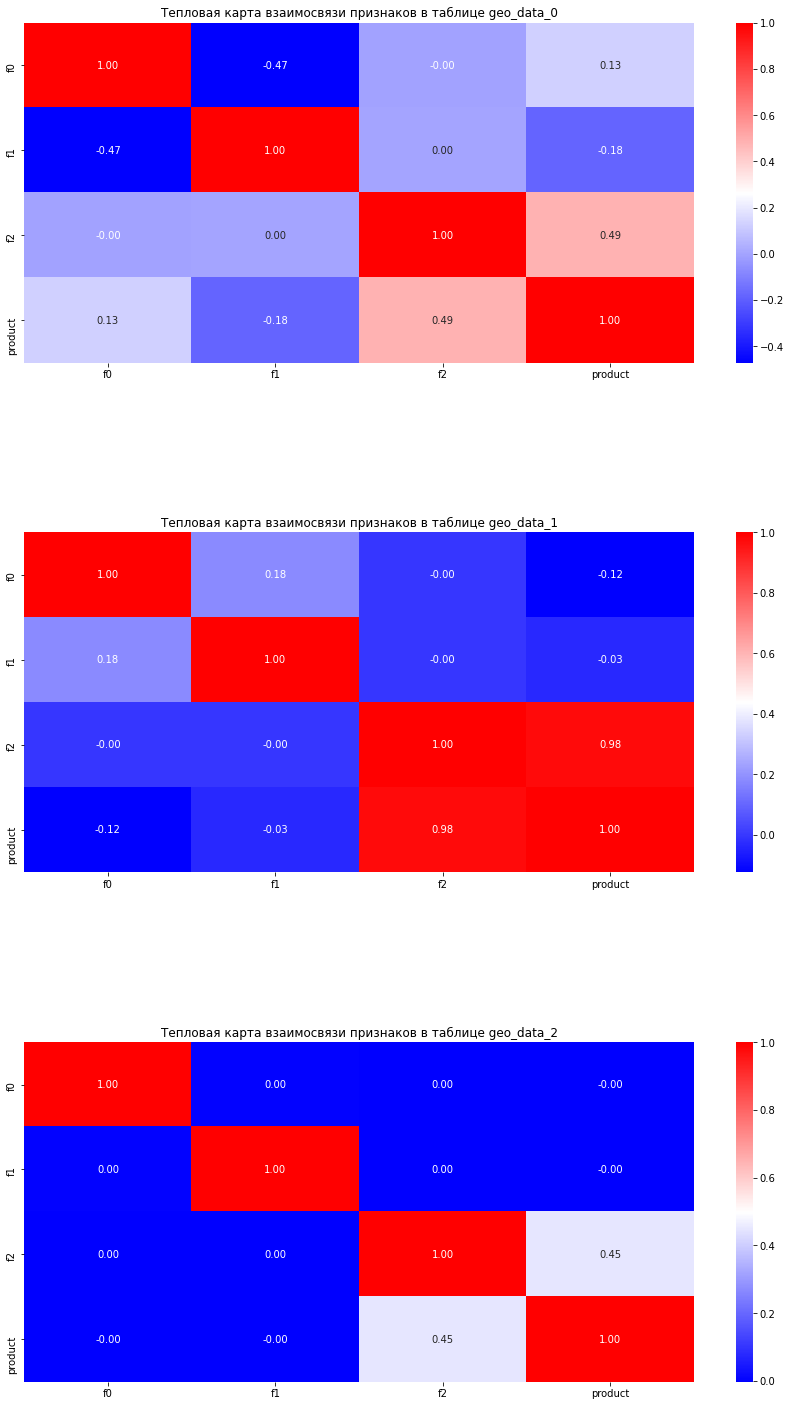

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15,25))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
axe = axes.ravel()
i=0
for table in tables:
    sns.heatmap(table.corr(method='spearman'), annot=True, fmt='.2f', cmap='bwr', ax=axe[i])
    axe[i].set_title(f'Тепловая карта взаимосвязи признаков в таблице geo_data_{i}')
    i+=1
None

Наиболее сильно на целевой product влияет признак f2 - это характерно для всех датасетов. При этом для второго региона (таблица geo_data_1) соответствующий коэффициент корреляции равен 0.98, а значит подтверждается ранее отмеченное предположение о том, что целевой product сгруппировался вокруг конкретных значений в соответствии с аналогичной группировкой в распределении признака f2.    
В третьем регионе (geo_data_2) на целевой влияет только признак f2, при этом связь нельзя назвать сильной, значение коэффициента составляет 0.45. Проверим, что изменится, если возвести значения признаков f0, f1 и f2 в квадрат.

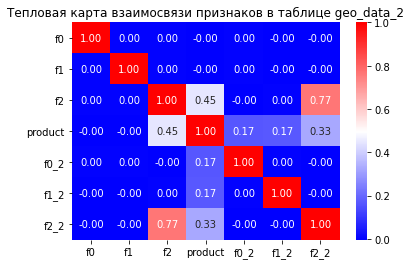

In [ ]:
geo_data_2['f0_2'] = geo_data_2['f0']**2
geo_data_2['f1_2'] = geo_data_2['f1']**2
geo_data_2['f2_2'] = geo_data_2['f2']**2
sns.heatmap(geo_data_2.corr(method='spearman'), annot=True, fmt='.2f', cmap='bwr')
plt.title('Тепловая карта взаимосвязи признаков в таблице geo_data_2')
None

Коэффициенты корреляции между f0, f1 и целевым выросли до 0.17. Связь по-прежнему незначительная, но уже лучше чем 0. А вот влияние f2 на целевой снизилось. Оставим квадраты f0 и f1, а вот квадрат f2 исключим из датасета.    

Дополнительно отмечу, что попробовал возвести в квадраты признаки и в других датасетах, однако это не дало роста коэффициентов корреляции.

In [ ]:
geo_data_2 = geo_data_2.drop('f2_2', axis=1)
geo_data_2.head()

,f0,f1,f2,product,f0_2,f1_2
0,-1.146987,0.963328,-0.828965,27.758673,1.315579,0.928001
1,0.262778,0.269839,-2.530187,56.069697,0.069052,0.072813
2,0.194587,0.289035,-5.586433,62.871910,0.037864,0.083541
3,2.236060,-0.553760,0.930038,114.572842,4.999963,0.306650
4,-0.515993,1.716266,5.899011,149.600746,0.266249,2.945567


### Промежуточный вывод

Таблицы с данными по 3 регионам открыты и изучены. Для каждого региона предоставлены данные о 100000 скважинах, пропуски отсутствуют. Особенности данных следующие:     
- В каждой из таблиц обнаружены дубли скважин по id: 10 в таблице geo_data_0 и по 4 в таблицах geo_data_1 и geo_data_2. При этом значения признаков для дублей отличаются от оригиналов. Возможная причина данной проблемы - ошибочное именование скважин уже используемыми id на этапе сбора и подготовки данных. Указанные дубли из таблиц не удалялись, однако номера id дублей сохранены в отдельные переменные для предоставления заказчику.     
- Распределения признаков f0, f1 и f2 различаются в каждом из датасетов, при этом различия наблюдаются как в характере распределений, так и в диапазоне значений признаков. Из чего мы сделали вывод, что либо в каждом из датасетов за указанными признаками скрываются разные характеристики скважин, либо данные признаки являются характеристиками региона по отношению к некоему эталону либо нулевому километру. Тем не менее, на качество иссследования обнаруженные различия повлиять не должны;    
- Признак f2 в geo_data_0 и geo_data_2 имеет почти идеально нормальное распределение, в то время как в geo_data_1 его значения сгруппировались вокруг шести цифр от 0 до 5 включительно;     
- Запасы нефти в geo_data_1 также распределились вокруг шести конкретных значений. Это связано с высоким влиянием признака f2 (коэффициент корреляции 0.98). Из чего мы сделали вывод, что в датасете geo_data_1 указаны не реальные, а предсказанные запасы нефти, причем признак f2 является определяющим для этого предсказания;     
- В остальных датасетах признак f2 также является наиболее сильно связанным с целевым запасом нефти, однако там его влияние не так велико (коэффициенты корреляции 0.49 и 0.45 соответственно);     
- Принято решение о возведении признаков f0 и f1 в датасете geo_data_2 в квадрат - это повысило коэффициенты корреляции между ними и целевым.     
- Во всех датасетах обнаружены скважины с нулевыми запасами нефти. В geo_data_0 и geo_data_2 их по 1 штуке, а вот в geo_data_1 чуть более 8% от всего датасета. Пустые скажины не исключались, так как они требуются для обучения моделей, а также для оценки прибыльности регионов.

## 2. Обучение и проверка модели

### 2.1. Подготовка функций для работы с моделями

Напишем универсальную функцию для подготовки выборок, обучения модели и получения предсказания. Согласно условию заказчика, соотношение обучающей и тренировочной выборки должно быть 75:25, а модель - линейная регрессия. Все входные признаки у нас количественные, поэтому используем StandardScaler для стандартизации.

In [ ]:
def linear_model(data):

    RANDOM_STATE = 42

    X = data.drop('product', axis=1)
    y = data['product']

    RANDOM_STATE = 42
    TEST_SIZE = 0.25

    X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)

    predictions = model_lr.predict(X_test)

    return y_test, predictions

Напишем универсальную функцию для расчета значения метрики RMSE

In [ ]:
def rmse(y_test, y_pred):
    return round(mean_squared_error(y_test, y_pred, squared=False),2)

Универсальные функции готовы. Для каждого региона сделаем предсказание запасов сырья в скважинах на валидационной выборке, оценим RMSE модели и рассчитаем средний запас предсказанного сырья.

### 2.2. Предсказание запасов сырья для первого региона (geo_data_0)

Обучим модель и сделаем предсказание для валидационной выборки первого региона. Рассчитаем RMSE.

In [ ]:
y_test0, y_pred0 = linear_model(geo_data_0)
rmse0 = rmse(y_test0, y_pred0)
print('Значение RMSE для модели первого региона:', rmse0)

Значение RMSE для модели первого региона: 37.76


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE получился очень высоким, модель плохо предсказала значения целевого признака. Сравним средний объем реального и предсказанного сырья

In [ ]:
mean_test0 = y_test0.mean()
print('Средний объем реального сырья на валидационной выборке: ', mean_test0)
mean_pred0 = y_pred0.mean()
print('Средний объем предсказанного сырья на валидационной выборке: ', mean_pred0)

Средний объем реального сырья на валидационной выборке:  92.32595637084387
Средний объем предсказанного сырья на валидационной выборке:  92.39879990657768


А вот средние объемы почти совпадают. Посмотрим на графики распределений.

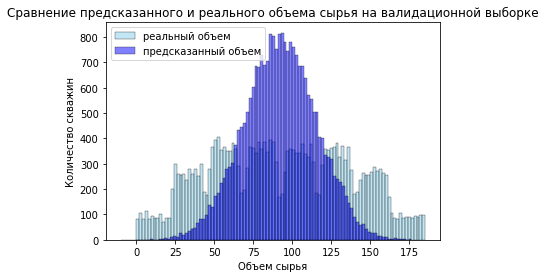

In [ ]:
sns.histplot(data=y_test0, bins=100, alpha=0.5, color='skyblue', label='реальный объем')
sns.histplot(data=y_pred0, bins=100, alpha=0.5, color='blue', label='предсказанный объем')
plt.xlabel('Объем сырья')
plt.ylabel('Количество скважин')
plt.title('Сравнение предсказанного и реального объема сырья на валидационной выборке')
plt.legend()
None

Реальные значения объема неравномерно разбросаны в широком диапазоне, в то время как предсказанные нормально распределилсь вокруг среднего. В целом график предсказаний представляет собой 'сжатый' график распределения реальных значений.

### 2.3. Предсказание запасов сырья для второго региона (geo_data_1)

In [ ]:
y_test1, y_pred1 = linear_model(geo_data_1)
rmse1 = rmse(y_test1, y_pred1)
print('Значение RMSE для модели второго региона:', rmse1)

Значение RMSE для модели второго региона: 0.89


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE очень низкий, модель хорошо справилась с предсказаниями целевого, но это и неудивительно - на этапе корреляционного анализа мы определили, что значения входного признака f2 очень сильно влияют на целевой. Сравним средние объемы.

In [ ]:
mean_test1 = y_test1.mean()
print('Средний объем реального сырья: ', mean_test1)
mean_pred1 = y_pred1.mean()
print('Средний объем предсказанного сырья: ', mean_pred1)

Средний объем реального сырья:  68.72538074722745
Средний объем предсказанного сырья:  68.7128780391376


Разница заметна, начиная с сотых долей значений. Посмотрим график.

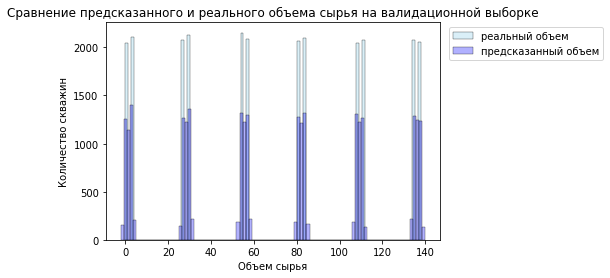

In [ ]:
sns.histplot(data=y_test1, bins=100, alpha=0.3, color='skyblue', label='реальный объем')
sns.histplot(data=y_pred1, bins=100, alpha=0.3, color='blue', label='предсказанный объем')
plt.xlabel('Объем сырья')
plt.ylabel('Количество скважин')
plt.title('Сравнение предсказанного и реального объема сырья на валидационной выборке')
plt.legend(bbox_to_anchor=(1.5, 1.0), ncol=1)
None

Струтура распределения предсказаний напоминает структуру распределения реальных значений - целевой признак распределился вокруг конкретных цифр. Существенное отличие - предсказания более усреднены по сравнению с реальными данными.

### 2.4. Предсказание запасов сырья для третьего региона (geo_data_2)

In [ ]:
y_test2, y_pred2 = linear_model(geo_data_2)
rmse2 = rmse(y_test2, y_pred2)
print('Значение RMSE для модели второго региона:', rmse2)

Значение RMSE для модели второго региона: 38.88


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Как и в случае с первым регионом, RMSE очень высок. Предсказания далеки от реальности. Сравним средние объемы.

In [ ]:
mean_test2 = y_test2.mean()
print('Средний объем реального сырья: ', mean_test2)
mean_pred2 = y_pred2.mean()
print('Средний объем предсказанного сырья: ', mean_pred2)

Средний объем реального сырья:  95.15099907171961
Средний объем предсказанного сырья:  94.76063334974505


Средний предсказанный объем чуть ниже реального. Сравним распределения.

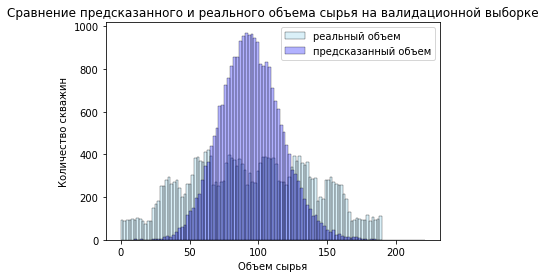

In [ ]:
sns.histplot(data=y_test2, bins=100, alpha=0.3, color='skyblue', label='реальный объем')
sns.histplot(data=y_pred2, bins=100, alpha=0.3, color='blue', label='предсказанный объем')
plt.xlabel('Объем сырья')
plt.ylabel('Количество скважин')
plt.title('Сравнение предсказанного и реального объема сырья на валидационной выборке')
plt.legend()
None

График напоминает аналогичный для первого региона. Реальные значения распределены неравномерно в широком диапазоне, а предсказания представляют почти нормальное распределение в более узких границах.

### Промежуточный вывод

Данные для каждого региона поделены на обучающую и валидационную выборки в соотношении 75:25. При помощи модели линейной регрессии сделаны предсказания объемов сырья на валидационных выборках. Оценка предсказаний осуществлена с использованием метрики RMSE.    

Качество предсказаний для первого и третьего региона находится на очень низком уровне (RMSE 37.87 и 38.79), однако значения предсказаний распределились в том же диапазоне, что и реальный целевой признак. Среднее значение предсказаний близки к реальным данным.    
Модель для второго региона, наоборот, показала высокий результат - RMSE равно 0.88. Среднее предсказаний почти идентично реальному среднему.    

Итого средний предсказанный запас нефти на валидационной выборке составил:    
92.39 для первого региона     
68.71 для второго региона     
94.76 для третьего региона

## 3. Подготовка к расчёту прибыли

Подготовим переменные, необходимые для расчета прибыли. Сначала объединим реальные и предсказанные значения объемов сырья в таблицы для удобства дальнейшей работы.

In [ ]:
reg0 = pd.DataFrame(zip(y_test0, y_pred0), columns = ['true', 'preds'])
reg1 = pd.DataFrame(zip(y_test1, y_pred1), columns = ['true', 'preds'])
reg2 = pd.DataFrame(zip(y_test2, y_pred2), columns = ['true', 'preds'])

На разработку региона выделено 10 миллиардов рублей, под разработкой региона подразумевается разработка 200 скважин. Создадим основные переменные с константами для дальнейших расчетов и определим стоимость разработки 1 новой скважины.

In [ ]:
TOTAL_EXPENCES = 10_000_000_000 # бюджет на разработку региона
TOTAL_WELL = 200 # количество скважин для разработки
WELL_EXPENCE = TOTAL_EXPENCES /TOTAL_WELL # стоимость разработки 1 скважины
BARREL_PRICE = 450_000 # стоимость 1000 баррелей
print(f'Стоимость разработки новой скважины: {WELL_EXPENCE} рублей')

Стоимость разработки новой скважины: 50000000.0 рублей


Прибыль рассчитывается по формуле    
***Чистая прибыль = Операционная прибыль - налоги - обслуживание долга***    
где     
***Операционная прибыль = Валовая прибыль – операционные расходы     
Валовая прибыль = оборот - себестоимость***    

Налоги и обслуживание долга заказчик не указал, будем считать, что эти показатели включены в бюджет на разработку скважин.    
Операционные расходы и себестоимость включены в бюджет на разработку скважин. Исходя из этого, напишем функцию рассчета прибыли при разработке новой скважины. Найдем точку безубыточности, т.е. тот объем сырья, при котором доходы будут равны расходам.

In [ ]:
null_size = (0 + WELL_EXPENCE) / BARREL_PRICE
print(f'Минимум сырья для безубыточности: {null_size} тысяч баррелей')

Минимум сырья для безубыточности: 111.11111111111111 тысяч баррелей


Сравним средние значения объемов сырья в каждом регионе с полученным значением безубыточности.

In [ ]:
print(f'Средний объем сырья в первом регионе: {mean_test0} тысяч баррелей')
print(f'Средний объем сырья во втором регионе: {mean_test1} тысяч баррелей')
print(f'Средний объем сырья в третьем регионе: {mean_test2} тысяч баррелей')
print(f'Минимум сырья для безубыточности: {null_size} тысяч баррелей')

Средний объем сырья в первом регионе: 92.32595637084387 тысяч баррелей
Средний объем сырья во втором регионе: 68.72538074722745 тысяч баррелей
Средний объем сырья в третьем регионе: 95.15099907171961 тысяч баррелей
Минимум сырья для безубыточности: 111.11111111111111 тысяч баррелей


Для безубыточной разработки скважины требуется, чтобы она содержала не менее 111.11 баррелей нефти. При таком значении доходы будут равны расходам. Если нас интересует получение чистой прибыли, то количество сырья должно быть больше указанного значения. Если ориентироваться только на средний объем сырья, то ни один из регионов не подходит для разработки, а значит требуются дополнительные методы для оценки прибыльности регионов.

## 4. Расчёт прибыли и рисков

### 4.1. Расчёт прибыли по лучшим скважинам

Для каждого региона необходимо отобрать 200 скважин с самыми высокими значениями предсказаний, просуммировать по ним реальный объем, а затем посчитать прибыль. Напишем функцию для расчета прибыли с учетом указанных условий.

In [ ]:
def reg_profit(data):
    pred_sorted = data['preds'].sort_values(ascending=False)
    selected = data['true']
    selected = selected[pred_sorted.index][:TOTAL_WELL]
    return round(selected.sum()*BARREL_PRICE - TOTAL_EXPENCES, 2)

Посчитаем прибыль для каждого региона с учетом запасов в 200 лучших скважинах.

In [ ]:
print(f'Прибыль с 200 лучших скважин первого региона - {reg_profit(reg0)} рублей')
print(f'Прибыль с 200 лучших скважин второго региона - {reg_profit(reg1)} рублей')
print(f'Прибыль с 200 лучших скважин третьего региона - {reg_profit(reg2)} рублей')

Прибыль с 200 лучших скважин первого региона - 3359141114.46 рублей
Прибыль с 200 лучших скважин второго региона - 2415086696.68 рублей
Прибыль с 200 лучших скважин третьего региона - 2852369935.39 рублей


Самым выгодным для разработки является первый регион (geo_data_0), а наименьшая прибыль может быть получена с 200 лучших скважин второго региона. Но это при условии, что мы целеноправленно отберем 200 лучших скважин в регионе и будем разрабатывать конкретно их. Используем иные методы для оценки прибыльности регионов.   

### 4.2. Применение техники Bootstrap и расчет доверительных интервалов

Применим технику Bootstrap, чтобы найти распределение прибыли. Использовать будем 1000 выборок по 500 скважин, в каждой из которых отберем 200 лучших. Создадим функцию для бутстрепа.

In [ ]:
def boot(data):
    state = np.random.RandomState(12345)
    values = []
    for i in range(1000):
        subsample = data.sample(n=500, replace=True, random_state=state)
        values.append(reg_profit(subsample))
    return values

Найдем распределение прибыли для каждого региона

In [ ]:
profit_reg0 = boot(reg0)
profit_reg1 = boot(reg1)
profit_reg2 = boot(reg2)

Визуализируем полученные распределения

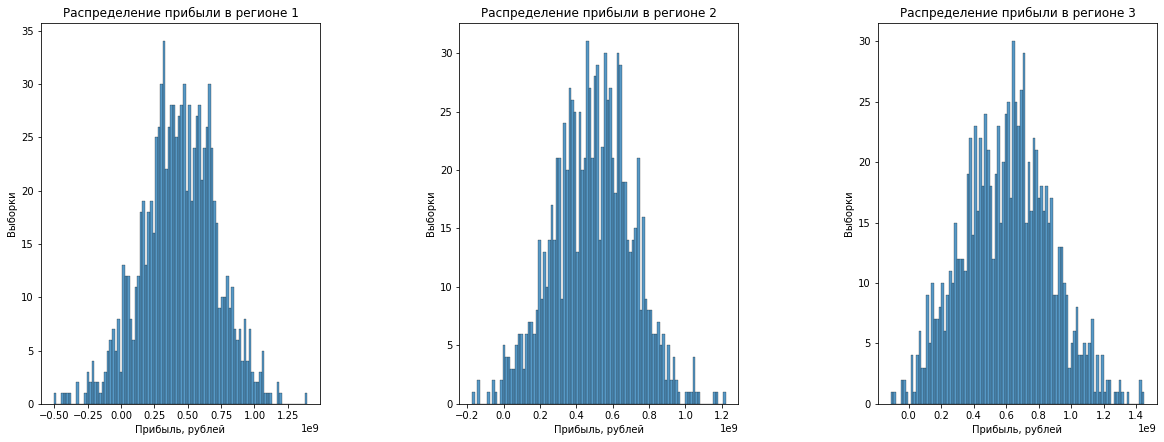

In [ ]:
regs = [profit_reg0, profit_reg1, profit_reg2]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,7))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
axe = axes.ravel()
i=0
n=1
for reg in regs:
    sns.histplot(reg, bins=100, ax=axe[i])
    axe[i].set_title(f'Распределение прибыли в регионе {n}')
    axe[i].set_xlabel('Прибыль, рублей')
    axe[i].set_ylabel('Выборки')
    i+=1
    n+=1

На графиках самым привлекательным выглядит третий регион, т.к. там минимум выборок с отрицательной прибылью и есть возможность получить самую высокую прибыль. А вот первый регион выглядит наименее прибыльным. Посчитаем среднюю прибыль для каждого региона.

In [ ]:
reg_mean0 = round(sum(profit_reg0)/len(profit_reg0), 2)
reg_mean1 = round(sum(profit_reg1)/len(profit_reg1), 2)
reg_mean2 = round(sum(profit_reg2)/len(profit_reg2), 2)
print(f'Средняя прибыль для первого региона - {reg_mean0} рублей')
print(f'Средняя прибыль для второго региона - {reg_mean1} рублей')
print(f'Средняя прибыль для третьего региона - {reg_mean2} рублей')

Средняя прибыль для первого региона - 435933772.14 рублей
Средняя прибыль для второго региона - 489661254.41 рублей
Средняя прибыль для третьего региона - 603541734.65 рублей


Самая высокое значение средней прибыли соответствует третьему региону.    

Построим 95% доверительный интервал для каждого региона, т.е. тот диапазон распределения прибыли, в которой с вероятностью 95% попадет истинное значение прибыли случайно выбранного месторождения данного региона.

In [ ]:
profit_reg0 = pd.Series(profit_reg0).sort_values(ascending=True)
profit_reg1 = pd.Series(profit_reg1).sort_values(ascending=True)
profit_reg2 = pd.Series(profit_reg2).sort_values(ascending=True)
conf_int_0_1 = round(profit_reg0.quantile(0.025), 2)
conf_int_0_2 = round(profit_reg0.quantile(0.975), 2)
conf_int_1_1 = round(profit_reg1.quantile(0.025), 2)
conf_int_1_2 = round(profit_reg1.quantile(0.975), 2)
conf_int_2_1 = round(profit_reg2.quantile(0.025), 2)
conf_int_2_2 = round(profit_reg2.quantile(0.975), 2)
print(f'95%-й доверительный интервал для первого региона: {conf_int_0_1} - {conf_int_0_2}')
print(f'95%-й доверительный интервал для второго региона: {conf_int_1_1} - {conf_int_1_2}')
print(f'95%-й доверительный интервал для третьего региона: {conf_int_2_1} - {conf_int_2_2}')

95%-й доверительный интервал для первого региона: -116231612.78 - 966504180.71
95%-й доверительный интервал для второго региона: 55116177.28 - 905762650.42
95%-й доверительный интервал для третьего региона: 93903301.05 - 1135701073.8


Значения границ 95%-го доверительного интервала распределения прибыли для третьего региона значительно выше, чем для первых двух. С точки зрения получения максимальной прибыли он однозначно лучше. Осталось только оценить риски убытков.    

Для оценки риска убытка в регионе нам нужно найти значение нижнего квантиля, после которого достигается точка безубыточности. Регион, в котором это значение будет наименьшим, можно считать наименее рискованным. Найдем такой квантиль для каждого региона.

In [ ]:
regions = [profit_reg0, profit_reg1, profit_reg2]
quantiles = []
for reg in regions:
    quan = 0.001
    lower = reg.quantile(quan)
    while lower < 0:
        lower = reg.quantile(quan+0.001)
        if lower > 0:
            quantiles.append(quan)
            break
        else:
            quan += 0.001
print(quantiles)

[0.06100000000000005, 0.011000000000000003, 0.007]


<a id='вопрос'></a>

Нижние квантили найдены. Самый прибыльный регион с минимальным риском убытков уже понятен, но для наглядности сведем все данные в единую таблицу.

In [ ]:
pd.set_option('max_colwidth', 120)
final = pd.DataFrame([['Средняя прибыль, тыс руб', round(reg_mean0/1000, 2), round(reg_mean1/1000, 2), round(reg_mean2/1000, 2)],
                      ['95-й доверительный интервал, нижняя граница, тыс руб', round(conf_int_0_1/1000, 2),
                       round(conf_int_1_1/1000, 2), round(conf_int_2_1/1000, 2)],
                       ['95-й доверительный интервал, верхняя граница, тыс руб', round(conf_int_0_2/1000, 2),
                       round(conf_int_1_2/1000, 2), round(conf_int_2_2/1000, 2)],
                      ['Вероятность убытка, %', quantiles[0]*100, quantiles[1]*100, quantiles[2]*100]],
                    columns=['Категория для сравнения', 'Первый регион', 'Второй регион', 'Третий регион'])
display(final)

,Категория для сравнения,Первый регион,Второй регион,Третий регион
0,"Средняя прибыль, тыс руб",435933.77,489661.25,603541.73
1,"95-й доверительный интервал, нижняя граница, тыс руб",-116231.61,55116.18,93903.30
2,"95-й доверительный интервал, верхняя граница, тыс руб",966504.18,905762.65,1135701.07
3,"Вероятность убытка, %",6.00,1.00,0.60


Первый регион не подходит для разработки из-за высокого риска убытков - 6%. К тому же здесь самые низкие значения границ 95%-го доверительного интервала. Во втором регионе, несмотря на большое количество пустых скважин, риск убытков всего 1%, что соответствует требованиям заказчика, а границы доверительного интервала выше, чем у первого региона. К разработке же мы рекомендуем третий регион. Риск убытков здесь минимален (0.6%), средняя прибыль и доверительный интервал самые высокие.

## Общий вывод исследования

В рамках данного проекта необходимо было решить следующую задачу - исследовать данные о скважинах и запах нефти в 3 регионах и выбрать регион, добыча нефти в котором принесет максимальную прибыль при минимальных рисках.    

Для решения задачи заказчик предоставил данные о 3 регионах, в каждом по 100000 скважин.    

Сначала опишем качество исходных данных.

**Исходные данные**    

В целом качество данных можно охарактеризовать как высокое. Пропуски и полные дубли отсутствуют, содержание таблиц соответствует описанию. Но есть замечания:     
- В каждой из таблиц обнаружены дубли скважин по id: 10 в таблице geo_data_0 и по 4 в таблицах geo_data_1 и geo_data_2. При этом значения признаков для дублей отличаются от оригиналов. Возможная причина данной проблемы - ошибочное именование скважин уже используемыми id на этапе сбора и подготовки данных. Указанные дубли из таблиц не удалялись, однако номера id дублей сохранены в отдельные переменные dup_id0, dup_id1 и dup_id2.
- Распределения признаков f0, f1 и f2 различаются в каждом из датасетов, при этом различия наблюдаются как в характере распределений, так и в диапазоне значений признаков. Из чего мы сделали вывод, что либо в каждом из датасетов за указанными признаками скрываются разные характеристики скважин, либо данные признаки являются характеристиками региона по отношению к некоему эталону либо нулевому километру.     
- Во всех датасетах обнаружены скважины с нулевыми запасами нефти. В geo_data_0 и geo_data_2 их по 1 штуке, а вот в geo_data_1 чуть более 8% от всего датасета. Пустые скажины не исключались, так как они потребовались для обучения моделей, а также для оценки прибыльности регионов.     

**Результаты исследования**

Определено, что для безубыточной разработки скважины она должна содержать не менее 111.11 тысяч баррелей нефти. Это при условии, что в бюджет на разработку скважин включены все операционные расходы (включая налоги). При таком значении доходы будут равны расходам. Если нас интересует получение чистой прибыли, то количество сырья должно быть больше указанного значения.   

Средний объем сырья:
- в первом регионе - 92.33 тысяч баррелей
- во втором регионе: 68.73 тысяч баррелей
- в третьем регионе: 95.15 тысяч баррелей      

Как видно, если ориентироваться только на среднее, то ни один из регионов не подходит для разработки.    

Тем не менее, в регионах есть прибыльные скважины с крупными запасами нефти, к тому же заказчик планирует разрабатывать не все скважины региона, а только 200. В связи с этим была проведена оценка прибыльности регионов с помощью методов ML, техники Bootstrap и доверительных интервалов. Результаты можно видеть в таблице ниже.

In [ ]:
display(final)

,Категория для сравнения,Первый регион,Второй регион,Третий регион
0,"Средняя прибыль, тыс руб",435933.77,489661.25,603541.73
1,"95-й доверительный интервал, нижняя граница, тыс руб",-116231.61,55116.18,93903.30
2,"95-й доверительный интервал, верхняя граница, тыс руб",966504.18,905762.65,1135701.07
3,"Вероятность убытка, %",6.00,1.00,0.60


Для разработки рекомендован 3-й регион (таблица geo_data_2). С 95% вероятностью средняя прибыль с разработки 200 скважин находится в диапазоне от 93903.30 до 1135701.07 тыс руб. При этом вероятность понести убытки менее 1%.